In [1]:
import os
import torch
import numpy as np
import pandas as pd
import wfdb
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from app.ecg.ecg import Datasets, EcgSignal
from sklearn.metrics import confusion_matrix, classification_report

ptbxl_data = pd.read_csv(r'C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\labels.csv', index_col=0)
# ptbxl_statements = pd.read_csv(Datasets.ptbxl_scp_statements.path, index_col=0)
# ptbxl_data['patient_id'] = ptbxl_data['patient_id'].astype(int)
# ptbxl_data['nurse'] = ptbxl_data['nurse'].astype('Int64')
# ptbxl_data['site'] = ptbxl_data['site'].astype('Int64')
# ptbxl_data['validated_by'] = ptbxl_data['validated_by'].astype('Int64')


In [4]:
ptbxl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 15709.0 to 11744.0
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           21388 non-null  float64
 1   sex                           21388 non-null  int64  
 2   height                        6918 non-null   float64
 3   weight                        9366 non-null   float64
 4   nurse                         19949 non-null  float64
 5   site                          21372 non-null  float64
 6   device                        21388 non-null  object 
 7   recording_date                21388 non-null  object 
 8   report                        21388 non-null  object 
 9   scp_codes                     21388 non-null  object 
 10  heart_axis                    13228 non-null  object 
 11  infarction_stadium1           5600 non-null   object 
 12  infarction_stadium2           103 non-null    object 
 13

In [15]:

def get_file_paths(filename):
    filename_lr = filename.split('/')[-1].split('_')[0]
    return fr"C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\{filename_lr}.npy"

clean_tags = lambda x: [e.replace("'", "")  for e in x[1:-1].split(', ')]
ptbxl_data["file_paths"] = ptbxl_data["filename_lr"].apply(get_file_paths)
ptbxl_data["superdiagnostic"] = ptbxl_data["superdiagnostic"].apply(clean_tags)

In [3]:
ptbxl_data

,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,...,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_codes_len,superdiagnostic,superdiagnostic_len,file_paths
patient_id,,,,,,,,,,,,,,,,,,,,,
15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",...,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,3,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00001.npy
13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",...,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00002.npy
20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",...,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00003.npy
17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",...,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00004.npy
17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",...,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00005.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,"ventrikulÄre extrasystole(n) sinustachykardie linkstyp mÄssige amplitudenkriterien fÜr linkshypertrophie st & t abnorm, wahrscheinlich anterolaterale ischÄmie oder linksbelastung 4.46 unbestÄtigter bericht","{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'STACH': 0.0}",...,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,4,[STTC],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\21833.npy
20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm inferiorer infarkt wahrscheinlich alt 4.46 unbestÄtigter bericht,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",...,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,3,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\21834.npy
19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,"sinusrhythmus lagetyp normal t abnorm in anterioren ableitungen 4.46 unbestÄtigter bericht Edit: INJAS 50, (ISCAS)","{'ISCAS': 50.0, 'SR': 0.0}",...,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,2,[STTC],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\21835.npy


# Data preparation

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(ptbxl_data["superdiagnostic"].values)
mlb.classes_.tolist()

['CD', 'HYP', 'MI', 'NORM', 'STTC']

In [17]:
train_labels = mlb.transform(ptbxl_data["superdiagnostic"].tolist())
ptbxl_data[mlb.classes_.tolist()] = train_labels

# ECGNet

In [ ]:
ecg_idx = pd.read_csv(r'C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\ptbxl_database.csv')
ptbxl_data['ecg_id']=ecg_idx['ecg_id']

In [18]:
from app.ecg.ecg import EcgDataset

valid_df = ptbxl_data[ptbxl_data['strat_fold'] == 9]
test_df = ptbxl_data[ptbxl_data['strat_fold'] == 10]

dataset = EcgDataset(ptbxl_data)
valid_dataset = EcgDataset(valid_df)
test_dataset = EcgDataset(test_df)


CQT kernels created, time used = 0.0460 seconds
CQT kernels created, time used = 0.0053 seconds
CQT kernels created, time used = 0.0056 seconds


C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [ ]:
import torch
from sklearn.metrics import roc_auc_score
from models.ecgnet import ECGNet
import matplotlib.pyplot as plt
import joblib
import numpy as np

model = ECGNet()
model = model.double()
model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\ecgnet_weights_authors.pt'
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
model.eval()

In [ ]:
ecg, label = valid_dataset[151]
label

In [ ]:
prediction = model(ecg)
prediction

In [ ]:
softmaxed_pred = torch.softmax(prediction, dim=1).to(torch.float64)

In [ ]:
print(softmaxed_pred.detach().numpy(), label.numpy().astype(int))

In [ ]:
roc_auc_score(label.numpy().astype(int), prediction.detach().numpy().reshape(-1), average='macro')

In [ ]:
len(test_dataset)

In [ ]:
gt_all = []
pred_all = []

for id in tqdm(range(len(test_dataset))):
    ecg , label = test_dataset[id]
    # print(ecg, label)
    prediction = model(ecg)
    pred_all.append(prediction.detach().numpy())
    gt_all.append(label.detach().numpy().astype(int))
gt_all_array = np.vstack(gt_all)
pred_all_array = np.vstack(pred_all)


In [ ]:
gt_all_array

In [65]:
from models.metrics import Metrics, metric_summary, AUC, roc_auc_score


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def evaluate_model(model, loader):
    gt_all = []
    pred_all = []
    for id in tqdm(range(len(loader))):
        ecg , label = loader[id]
        # print(ecg, label)
        prediction = model(ecg)
        # pred_all.append(prediction.detach().numpy())
        pred_all.append(prediction.detach().numpy())
        # pred_all.append(sigmoid(prediction.detach().numpy()))
        gt_all.append(label.detach().numpy().astype(int))
    gt_all_array = np.vstack(gt_all)
    pred_all_array = np.vstack(pred_all)
    roc_score = roc_auc_score(gt_all_array, pred_all_array, average="macro")
    acc, mean_acc = Metrics(gt_all_array, pred_all_array)
    class_auc = AUC(gt_all_array, pred_all_array)
    summary = metric_summary(gt_all_array, pred_all_array)
    print(f"class wise accuracy: {acc}")
    print(f"accuracy: {mean_acc}")
    print(f"roc_score : {roc_score}")
    print(f"class wise AUC : {class_auc}")
    print(f"F1 score (Max): {summary[0]}")
    print(f"class wise precision, recall, f1 score : {summary}")
    return gt_all_array, pred_all_array
    

## EcgNet scores

In [ ]:


Metrics(gt_all_array, pred_all_array)

In [ ]:
print("ecgNet(ptbxlv1.0.2) - test - aurroc- macro: ", roc_auc_score(gt_all_array, pred_all_array))

In [ ]:
roc_score = roc_auc_score(gt_all_array, pred_all_array, average="macro")
acc, mean_acc = Metrics(gt_all_array, pred_all_array)
class_auc = AUC(gt_all_array, pred_all_array)
summary = metric_summary(gt_all_array, pred_all_array)

print(f"class wise accuracy: {acc}")
print(f"accuracy: {mean_acc}")
print(f"roc_score : {roc_score}")
print(f"class wise AUC : {class_auc}")
print(f"F1 score (Max): {summary[0]}")
print(f"class wise precision, recall, f1 score : {summary}")

In [ ]:
pred_all_array

In [ ]:
pred_all_array.shape

In [ ]:
print("ecgNet - valid - aurroc- macro: ", roc_auc_score(np.vstack(gt_all), np.vstack(pred_all)))

# ResNet50 CQT

In [31]:
from models.nn.custom_model_cqt import CustomModel
from models.config import CqtCFG
import torch

model_resnet50cqt = CustomModel(CqtCFG)
# model = model.double()
model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\resnet50\resnet50d_fold9_best_score.pth'
model_resnet50cqt.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')), strict=False)
model_resnet50cqt.eval()


CustomModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(1, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          

In [ ]:
valid_dataset = EcgDataset(valid_df, feature='cqt')
test_dataset = EcgDataset(test_df, feature='cqt')

In [ ]:
cqt_im, label = valid_dataset[0]
# cqt_im = cqt_im[None, None, :]
cqt_im.shape

In [ ]:
model_resnet50cqt(cqt_im)

In [33]:
gt_v, labels_v = evaluate_model(model_resnet50cqt, valid_dataset)

100%|██████████| 2146/2146 [03:19<00:00, 10.74it/s]

class wise accuracy: [0.7688723205964585, 0.874650512581547, 0.7483690587138863, 0.554520037278658, 0.7539608574091333]
accuracy: 0.7400745573159366
roc_score : 0.48158220540497876
class wise AUC : [0.4902048957167067, 0.6007075246769349, 0.410993496609935, 0.431645280265165, 0.4743598297561523]
F1 score (Max): 0.39902638981000393
class wise precision, recall, f1 score : (0.39902638981000393, 0.48158220540497876, [0.39902638981000393, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.2630475302889096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.8260329294812053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0])



C:\Users\redmi\PycharmProjects\ecg-tool-api\models\metrics.py:145: RuntimeWarning: invalid value encountered in divide
  2


In [34]:
gt_t, labels_t = evaluate_model(model_resnet50cqt, test_dataset)

100%|██████████| 2158/2158 [03:06<00:00, 11.55it/s]


class wise accuracy: [0.7701575532900834, 0.8785912882298424, 0.7451343836886005, 0.5537534754402225, 0.7585727525486562]
accuracy: 0.7412418906394811
roc_score : 0.4783042559310203
class wise AUC : [0.4759435289779123, 0.5896564080265404, 0.4259294436906377, 0.42449719104784994, 0.4754947079121608]
F1 score (Max): 0.3997443915639605
class wise precision, recall, f1 score : (0.3997443915639605, 0.4783042559310203, [0.3997443915639605, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.26309082483781276, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.8317886932344764, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0])


In [21]:
len(valid_dataset)

2146

In [ ]:
from models.nn.xresnet1d import xresnet1d101
from models.nn.inception1d import inception1d
from models.nn.resnet1d import resnet1d_wang
from models.nn.rnn1d import RNN1d

def model_factory(model_name):
    model = None
    if model_name.lower()=='xresnet1d101':
        model = xresnet1d101(input_channels=12, num_classes=5)

    if model_name.lower()=='resnet1d_dwang':
        model = resnet1d_wang(input_channels=12, num_classes=5)

    if model_name.lower()=='inception1d_model':
        model = inception1d(input_channels=12, num_classes=5)

    if model_name.lower()=='rnn_1d':
        model = RNN1d(input_channels=12, num_classes=5)

    return model

# Xresnet1d

In [41]:
from models.nn.xresnet1d import xresnet1d101
import torch



xresnet1d_model = xresnet1d101(input_channels=12, num_classes=5)
xresnet1d_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\xresnet1d101\exp0_xresnet1d101xresnet1d101_fold1_19epoch_best_score.pth'
xresnet1d_model.load_state_dict(torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model'])
xresnet1d_model.double()
xresnet1d_model.eval()

XResNet1d(
  (0): ConvLayer(
    (0): Conv1d(12, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
    

In [45]:
torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model']

OrderedDict([('0.0.weight',
              tensor([[[ 1.8142e-01,  7.3431e-02,  5.3870e-02,  3.5905e-01,  1.3066e-01],
                       [ 1.8385e-01, -1.3094e-02,  2.9767e-01, -2.4098e-01, -1.8627e-01],
                       [ 1.3199e-01,  4.4830e-02,  2.1216e-01,  5.5411e-02, -4.7518e-01],
                       ...,
                       [-3.0620e-02, -8.0225e-02,  2.6821e-01, -1.3437e-01,  1.1454e-01],
                       [ 1.2754e-01, -1.2078e-01, -3.6862e-02,  1.4472e-02,  3.2900e-01],
                       [ 5.1923e-02, -1.9296e-01,  1.9608e-01,  1.5318e-01, -2.3305e-01]],
              
                      [[ 1.5843e-01,  8.3384e-02,  5.8071e-02, -2.7533e-01, -2.3064e-02],
                       [-7.6667e-02,  1.5067e-01,  2.9896e-02,  4.8615e-02,  1.1374e-01],
                       [ 1.0984e-01, -2.0519e-01, -3.3914e-01, -2.2472e-01, -1.9918e-01],
                       ...,
                       [-1.0513e-01, -1.6065e-01,  3.6400e-01,  2.0428e-02, -3.3001e-01],


In [8]:
ecg, label = valid_dataset[7]
ecg.shape

torch.Size([1, 12, 1000])

In [52]:
label

tensor([0., 0., 0., 1., 0.])

In [53]:
xresnet1d_model(ecg)

tensor([[-5.3253, -4.9247, -5.4436,  5.2726, -5.4596]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [34]:
test_dataset[107]

(tensor([[[ 0.0900,  0.0730,  0.0500,  ...,  0.0750,  0.0730,  0.0900],
          [-0.0350, -0.0520, -0.0780,  ..., -0.1060, -0.1050, -0.1040],
          [-0.1250, -0.1250, -0.1270,  ..., -0.1810, -0.1790, -0.1940],
          ...,
          [-0.1500, -0.1500, -0.1500,  ..., -0.2750, -0.2820, -0.2770],
          [ 0.1400,  0.1390,  0.1350,  ...,  0.1920,  0.2540,  0.3120],
          [ 0.0100,  0.0090,  0.0050,  ..., -0.2940, -0.2970, -0.2930]]],
        dtype=torch.float64),
 tensor([0., 0., 1., 0., 1.]))

In [54]:
evaluate_model(xresnet1d_model, test_dataset)

100%|██████████| 2158/2158 [00:39<00:00, 54.74it/s]

class wise accuracy: [0.8897126969416126, 0.9216867469879518, 0.8665430954587581, 0.8873957367933272, 0.9031510658016683]
accuracy: 0.8936978683966637
roc_score : 0.945232846766223
class wise AUC : [0.9417918559062147, 0.9382669823171321, 0.932451379466305, 0.958210265166821, 0.9554437509746423]
F1 score (Max): 0.8080090213529213
class wise precision, recall, f1 score : (0.8080090213529213, 0.945232846766223, [0.8080090213529213, 0.8041618410750325, 0.8005559699915934, 0.7979259734294084, 0.791585762440762, 0.7877588781528645, 0.7830403633295228, 0.7758309809935896, 0.7668490152751574, 0.7584454037942777], [0.8434701188731478, 0.8495703189555446, 0.8566565809379728, 0.8647435897435898, 0.8716169023921774, 0.8788485495639794, 0.8908849881148291, 0.8964660667416573, 0.9036714975845411, 0.9055489964580874], [0.775409329626197, 0.7633611368551128, 0.7513515600864997, 0.7406935434043868, 0.7250154464009887, 0.7137781896818042, 0.6984862527031201, 0.6838121717639789, 0.6660101946246525, 0.65

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[-3.9445402 , -5.17392056, -3.26830999,  3.12357277, -5.25319514],
        [-1.64896047, -4.99737425, -4.78981792,  3.16528685, -3.44972022],
        [-2.92633657, -3.56020432, -4.75886424,  2.19726658, -3.45016258],
        ...,
        [-3.35843216, -2.15863849, -2.3312406 ,  1.33540295, -4.82410338],
        [ 0.89151499, -4.07900148, -2.52005066, -0.22301925, -2.77432349],
        [-2.88676383, -5.28226944,  0.1416349 , -2.12537415, -1.57720985]]))

In [55]:
evaluate_model(xresnet1d_model, valid_dataset)

100%|██████████| 2146/2146 [01:00<00:00, 35.26it/s]


class wise accuracy: [0.9012115563839702, 0.9221808014911463, 0.8802423112767941, 0.8970177073625349, 0.8918918918918919]
accuracy: 0.8985088536812675
roc_score : 0.9487086238429022
class wise AUC : [0.9476852106773366, 0.9358697725430357, 0.9454268714542687, 0.9638844562842611, 0.9506768082556092]
F1 score (Max): 0.8211694718834347
class wise precision, recall, f1 score : (0.8211694718834347, 0.9487086238429022, [0.8211694718834347, 0.8180125045103792, 0.8157698383023614, 0.8081038861629387, 0.8047648564685581, 0.7985846057967387, 0.7900616418647007, 0.7844893277050097, 0.7772188207858182, 0.769764825544673], [0.8548122643056238, 0.8620804253904951, 0.870801687763713, 0.874593391542544, 0.8806047966631908, 0.8853283898305084, 0.8916938110749185, 0.8953734363502575, 0.9022435897435898, 0.910077519379845], [0.7900745573159367, 0.7782308170239204, 0.7672802112457284, 0.751009630319975, 0.7409521590556074, 0.7273221497359428, 0.7092264678471575, 0.6980428704566636, 0.6826265921093506, 0.6

(array([[0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]),
 array([[-3.1677591 , -3.90180522, -1.81254499,  1.32187091, -4.69090351],
        [-5.44434877, -6.47968096, -6.28095825,  5.6266861 , -5.46598626],
        [-1.24765092, -1.26739126, -1.03284439, -4.13920664,  2.75576176],
        ...,
        [-4.77860175, -5.69768495, -1.22651957, -3.50874596,  1.9376714 ],
        [-5.44661797, -6.4738648 , -4.4702851 ,  5.25229792, -6.22884795],
        [-4.89926612, -5.28330157, -5.26760933,  4.08361618, -4.03348173]]))

In [42]:
evaluate_model(xresnet1d_model, valid_dataset)

100%|██████████| 2146/2146 [01:01<00:00, 34.66it/s]

class wise accuracy: [0.9086672879776329, 0.924044734389562, 0.8951537744641193, 0.8937558247903076, 0.8970177073625349]
accuracy: 0.9037278657968313
roc_score : 0.9487086238429022
class wise AUC : [0.9476852106773366, 0.9358697725430357, 0.9454268714542687, 0.9638844562842611, 0.9506768082556092]
F1 score (Max): 0.8351283062259676
class wise precision, recall, f1 score : (0.8351283062259676, 0.9487086238429022, [0.4122521456052086, 0.8039341400928796, 0.8315700341856296, 0.8351283062259676, 0.8259049677528372, 0.8156711827034051, 0.7883597000969818, 0.7473742372870205, 0.6619919062367985, nan], [0.259645852749301, 0.6992932587760174, 0.7766246890547264, 0.8153809971777987, 0.8412373615792008, 0.8711775637776651, 0.892467248908297, 0.9225526641883519, 0.9547470005216483, nan], [1.0, 0.9454022988505748, 0.8948819509164336, 0.8558558558558558, 0.81112146629388, 0.7668142280211245, 0.7060034172103137, 0.6281065548306927, 0.5066402609506058, 0.0], [0.0, 0.1111111111111111, 0.22222222222222

(array([[0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]),
 array([[0.04039719, 0.01980523, 0.14033082, 0.78949281, 0.00909491],
        [0.00430207, 0.00153195, 0.00186811, 0.99641243, 0.00421037],
        [0.22310704, 0.21970415, 0.26253303, 0.01568553, 0.94023793],
        ...,
        [0.00833765, 0.00334251, 0.22679116, 0.0290644 , 0.8740961 ],
        [0.00429236, 0.00154087, 0.01131457, 0.99479179, 0.00196784],
        [0.00739693, 0.00505001, 0.00512947, 0.98343266, 0.01740428]]))

# ResNET1d_wang

In [43]:
from models.nn.resnet1d import resnet1d_wang
import torch

resnet1d_wang_model = resnet1d_wang(input_channels=12, num_classes=5)
resnet1d_wang_weights = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\resnet1d_wang\resnet1d_wang_fold1_16epoch_best_score.pth'
# xresnet1d_model.load_state_dict(torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model'])

resnet1d_wang_model.load_state_dict(torch.load(resnet1d_wang_weights, map_location=torch.device('cpu'))['model'])
resnet1d_wang_model.double()
resnet1d_wang_model.eval()



ResNet1d(
  (0): Conv1d(12, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (4): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False

In [11]:
resnet1d_wang_model(ecg)

tensor([[-3.4778, -3.9272, -4.5273,  3.4386, -4.4794]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [12]:
evaluate_model(resnet1d_wang_model, test_dataset)

100%|██████████| 2158/2158 [00:40<00:00, 52.82it/s]

class wise accuracy: [0.9119555143651529, 0.9272474513438369, 0.8897126969416126, 0.8934198331788693, 0.9040778498609824]
accuracy: 0.9052826691380907
roc_score : 0.9519354108684759
class wise AUC : [0.9458144093785179, 0.9414536831255838, 0.9578312980551786, 0.961587959523282, 0.9529897042598171]
F1 score (Max): 0.8293092983071139
class wise precision, recall, f1 score : (0.8293092983071139, 0.9519354108684759, [0.8293092983071139, 0.824009395552638, 0.8203824261197298, 0.8157066766948554, 0.8115561542500916, 0.805619734018517, 0.7997239338129407, 0.790707686015716, 0.7808625554212011, 0.7714658458705445], [0.8625895182291666, 0.8708686264740076, 0.8767641129032258, 0.8845097029022841, 0.8942021369767035, 0.9047040834682496, 0.9086996336996337, 0.9137591446257738, 0.9166666666666667, 0.9258268964151316], [0.7985016991041086, 0.7819354340438677, 0.7708140253320975, 0.7568350324374421, 0.7428946555452579, 0.7260966944701884, 0.7140871177015755, 0.6968643805993203, 0.6801050355267222, 0.

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[-2.66339326, -5.29602226, -2.89385369,  2.33851818, -4.72413427],
        [-0.23080978, -4.66203341, -3.30822062,  0.85252593, -3.50124264],
        [-1.55635372, -3.22963769, -3.15087489,  1.13181596, -3.40798393],
        ...,
        [-2.55091923, -1.6129529 , -1.08714386,  0.12585486, -4.37837511],
        [ 3.88926931, -2.08258841, -2.98448787, -1.36419389, -3.06046174],
        [-2.05338135, -4.74342537,  1.05190746, -1.97983718, -2.72900002]]))

In [13]:
evaluate_model(resnet1d_wang_model, valid_dataset)

100%|██████████| 2146/2146 [00:40<00:00, 53.44it/s]

class wise accuracy: [0.9114631873252563, 0.9161230195712954, 0.8946877912395154, 0.8951537744641193, 0.8928238583410997]
accuracy: 0.9020503261882572
roc_score : 0.955242851223654
class wise AUC : [0.9547748839087422, 0.9418562141369827, 0.9603593007702597, 0.9645016506873101, 0.9547222066149755]
F1 score (Max): 0.8306149669907514
class wise precision, recall, f1 score : (0.8306149669907514, 0.955242851223654, [0.8306149669907514, 0.8262283200747632, 0.8213426707617111, 0.8141857850536365, 0.8078183707730434, 0.8003694205160029, 0.7923585677203713, 0.7871001325562982, 0.7801469606959226, 0.7711295453543118], [0.8579295154185022, 0.8646401985111662, 0.8728313963281118, 0.8782216494845361, 0.8873375482964523, 0.8939475574712643, 0.9013266998341625, 0.9110481586402266, 0.9160393746381007, 0.9231763068972371], [0.8049860205032618, 0.7910841876359118, 0.7755902454178315, 0.7588536812674743, 0.7413793103448276, 0.7245262503883194, 0.7068965517241379, 0.6928393911152532, 0.6793647095371234, 

(array([[0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]),
 array([[-3.14832513, -3.26460991,  0.2536856 , -0.02308407, -3.61274702],
        [-4.19766302, -5.41535718, -4.84862716,  4.5559457 , -4.57813923],
        [-0.94796921, -2.48907457, -0.80158036, -2.77964796,  0.9146152 ],
        ...,
        [-4.12834013, -4.75765843, -0.12445068, -3.615529  ,  1.38919457],
        [-4.86035748, -6.23637954, -4.32480366,  4.19391938, -4.51776387],
        [-4.62028469, -5.38658484, -5.11096646,  4.1857975 , -4.0493642 ]]))

In [44]:
evaluate_model(resnet1d_wang_model, test_dataset)

100%|██████████| 2158/2158 [00:21<00:00, 98.98it/s]


class wise accuracy: [0.9133456904541242, 0.9304911955514366, 0.896663577386469, 0.8906394810009268, 0.9082483781278962]
accuracy: 0.9078776645041705
roc_score : 0.9519354108684759
class wise AUC : [0.9458144093785179, 0.9414536831255838, 0.9578312980551786, 0.961587959523282, 0.9529897042598171]
F1 score (Max): 0.8390414594282605
class wise precision, recall, f1 score : (0.8390414594282605, 0.9519354108684759, [0.41113238109262257, 0.7934017120716688, 0.8330273814507657, 0.8390414594282605, 0.8352409399496095, 0.8205759259958391, 0.7983611142836237, 0.7479615999138117, 0.6185842308793499, nan], [0.258758109360519, 0.6786299042323138, 0.7694238492431262, 0.8154205607476636, 0.8484017175572519, 0.8772062531517902, 0.910454629118351, 0.9400380710659898, 0.9629948364888123, nan], [1.0, 0.9548965091133768, 0.9080939141180105, 0.8640716713005869, 0.8224822366388632, 0.7708140253320975, 0.7108433734939759, 0.6210611677479148, 0.45563021316033364, 0.0], [0.0, 0.1111111111111111, 0.22222222222

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[0.06516831, 0.0049865 , 0.05245823, 0.91201725, 0.00880026],
        [0.44255236, 0.00935882, 0.03529025, 0.70109675, 0.02927689],
        [0.17417049, 0.03806551, 0.04105682, 0.75617387, 0.03204688],
        ...,
        [0.07236475, 0.16617905, 0.25215649, 0.53142225, 0.01239028],
        [0.97994994, 0.11080069, 0.0481316 , 0.20355953, 0.04476795],
        [0.11371116, 0.00863358, 0.74114102, 0.1213362 , 0.06128366]]))

# Inception1d

In [82]:
from models.nn.inception1d import inception1d

inception1d_model = inception1d(input_channels=12, num_classes=5)
inception1d_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\inception1d\inception1d_fold1_15epoch_best_score.pth'
inception1d_model.load_state_dict(torch.load(inception1d_model_weights_path, map_location=torch.device('cpu'))['model'])
inception1d_model.double()
inception1d_model.eval()

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [58]:
ecg, label

(tensor([[[ 0.0360,  0.0460,  0.0460,  ...,  0.0040, -0.1340, -0.3340],
          [-0.1140, -0.1040, -0.1060,  ..., -0.0060, -0.1450, -0.3110],
          [-0.1500, -0.1490, -0.1520,  ..., -0.0100, -0.0100,  0.0230],
          ...,
          [ 0.0210,  0.0230,  0.0170,  ..., -0.0880, -0.1230, -0.1090],
          [-0.0250, -0.0230, -0.0320,  ..., -0.0420, -0.0890, -0.1210],
          [ 0.0060,  0.0040, -0.0160,  ..., -0.1120, -0.1480, -0.1480]]],
        dtype=torch.float64),
 tensor([0., 0., 0., 1., 0.]))

In [59]:
inception1d_model(ecg)

tensor([[-4.4925, -4.6633, -4.5221,  3.2949, -3.5534]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [60]:
evaluate_model(inception1d_model, test_dataset)

100%|██████████| 2158/2158 [00:48<00:00, 44.18it/s]

class wise accuracy: [0.9138090824837812, 0.9207599629286376, 0.8887859128822985, 0.8980537534754403, 0.9045412418906394]
accuracy: 0.9051899907321594
roc_score : 0.9569492358010082
class wise AUC : [0.954472118706572, 0.9485739362901409, 0.960292853912257, 0.9650091024822187, 0.9563981676138529]
F1 score (Max): 0.8345535231120428
class wise precision, recall, f1 score : (0.8345535231120428, 0.9569492358010082, [0.8345535231120428, 0.8306702106588043, 0.8268053498758148, 0.819813458866716, 0.813922657858165, 0.8100104919261963, 0.800939796888839, 0.7931867633953288, 0.7889815056776961, 0.7796063832331508], [0.8703432568732715, 0.8780366881507189, 0.8851963746223565, 0.8921845574387948, 0.8958658346333853, 0.902336860670194, 0.9079089924160346, 0.9142170456646331, 0.925715368580633, 0.9332355816226784], [0.8015909793018227, 0.788152610441767, 0.7756410256410257, 0.7583024405313561, 0.745713623725672, 0.7348239110287303, 0.7165199258572753, 0.7004556688291628, 0.6874420759962928, 0.66940

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[-2.22023794, -5.01295134, -2.70663503,  1.89465267, -4.14693349],
        [ 0.3324141 , -4.08592618, -3.67161655,  1.15772968, -4.0388319 ],
        [-1.54339273, -3.06256439, -4.20844905,  2.203993  , -2.77911508],
        ...,
        [-2.36203804, -1.22312216, -0.88608206, -0.72825251, -3.85984596],
        [ 4.51332536, -3.03034121, -3.00525668, -1.98216501, -3.65007412],
        [-2.02133119, -5.12259159,  0.94243378, -3.00276813, -2.10483386]]))

In [62]:
e, l = test_dataset[107]
l

tensor([0., 0., 1., 0., 1.])

In [68]:
torch.softmax(inception1d_model(e), dim=1).detach().numpy()

array([[1.62190692e-03, 7.54639804e-04, 9.48442227e-01, 5.63857648e-04,
        4.86173686e-02]])

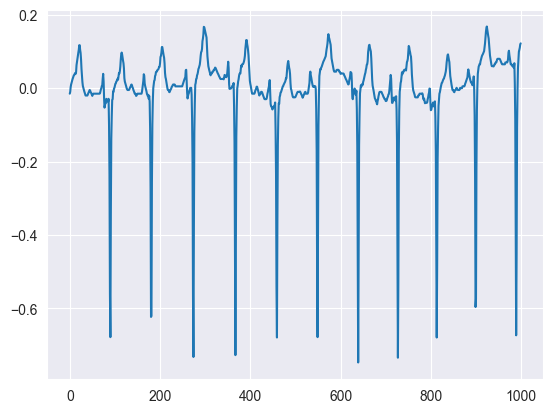

In [81]:
plt.plot(e[0,6].detach().numpy())

In [75]:
e[0,1]

tensor([-0.0350, -0.0520, -0.0780, -0.0730, -0.0770, -0.0800, -0.0800, -0.0780,
        -0.0710, -0.0670, -0.0610, -0.0550, -0.0500, -0.0430, -0.0320, -0.0230,
        -0.0120,  0.0070,  0.0260,  0.0500,  0.0810,  0.1050,  0.1340,  0.1570,
         0.1550,  0.1460,  0.1250,  0.0860,  0.0450,  0.0080, -0.0170, -0.0330,
        -0.0450, -0.0530, -0.0590, -0.0600, -0.0600, -0.0600, -0.0600, -0.0580,
        -0.0550, -0.0520, -0.0500, -0.0470, -0.0450, -0.0490, -0.0500, -0.0500,
        -0.0500, -0.0500, -0.0510, -0.0550, -0.0550, -0.0550, -0.0550, -0.0550,
        -0.0590, -0.0600, -0.0600, -0.0600, -0.0600, -0.0590, -0.0550, -0.0550,
        -0.0530, -0.0490, -0.0510, -0.0460, -0.0400, -0.0350, -0.0300, -0.0240,
        -0.0180,  0.0010,  0.0430,  0.0570,  0.0450,  0.0430,  0.0260, -0.0150,
        -0.0390, -0.0610, -0.0580, -0.0670, -0.0810, -0.0870, -0.0480,  0.0730,
         0.2420,  0.6750,  0.7510,  0.3080,  0.0960,  0.0180, -0.0190, -0.0290,
        -0.0460, -0.0480, -0.0590, -0.05

# RNN1d

In [17]:
from models.nn.rnn1d import RNN1d

rnn1d_model = RNN1d(input_channels=12, num_classes=5)
rnn1d_model.double()
rnn1d_model.eval()



NameError: name 'bn_drop_lin' is not defined

# Metrics

In [14]:
gt, scores = evaluate_model(xresnet1d_model, test_dataset)
# cm, y_pred = calculate_metrics(scores)

100%|██████████| 2158/2158 [00:41<00:00, 51.93it/s]

class wise accuracy: [0.8897126969416126, 0.9216867469879518, 0.8665430954587581, 0.8873957367933272, 0.9031510658016683]
accuracy: 0.8936978683966637
roc_score : 0.945232846766223
class wise AUC : [0.9417918559062147, 0.9382669823171321, 0.932451379466305, 0.958210265166821, 0.9554437509746423]
F1 score (Max): 0.8080090213529213
class wise precision, recall, f1 score : (0.8080090213529213, 0.945232846766223, [0.8080090213529213, 0.8041618410750325, 0.8005559699915934, 0.7979259734294084, 0.791585762440762, 0.7877588781528645, 0.7830403633295228, 0.7758309809935896, 0.7668490152751574, 0.7584454037942777], [0.8434701188731478, 0.8495703189555446, 0.8566565809379728, 0.8647435897435898, 0.8716169023921774, 0.8788485495639794, 0.8908849881148291, 0.8964660667416573, 0.9036714975845411, 0.9055489964580874], [0.775409329626197, 0.7633611368551128, 0.7513515600864997, 0.7406935434043868, 0.7250154464009887, 0.7137781896818042, 0.6984862527031201, 0.6838121717639789, 0.6660101946246525, 0.65

In [60]:
from sklearn.metrics import multilabel_confusion_matrix
from models.metrics import MR, multilabel_accuracy, zero_one_loss, multilabel_recall, multilabel_precision, multilabel_hamming_loss
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def calculate_metrics(scores):
    
    y_pred=[]
    for sample in  tqdm(scores):
      sample = sigmoid(sample)
      y_pred.append([1 if i>=0.5 else 0 for i in sample ] )
    y_pred = np.array(y_pred)
    
    confusion_matrix = multilabel_confusion_matrix(gt, y_pred)
    print("Confusion matrix: \n", confusion_matrix)
    
    match_ratio = MR(gt, y_pred)
    print("\nMR: ", match_ratio.round(3))
    
    mlb_accuracy = multilabel_accuracy(gt, y_pred)
    print("\nAccuracy: ", mlb_accuracy.round(3))

    zoneloss = zero_one_loss(gt, y_pred)
    print("\n0/1Loss: ", zoneloss.round(3))
    
    mlb_recall = multilabel_recall(gt, y_pred)
    print("\nRecall: ", mlb_recall.round(3))
    
    mlb_precision = multilabel_precision(gt, y_pred)
    print("\nPrecision: ", mlb_precision.round(3))
    
    mlb_hamming_loss = multilabel_hamming_loss(gt, y_pred)
    print("\nHamming loss: ", mlb_hamming_loss)

    return confusion_matrix, y_pred
   

   


In [84]:
cm, y_pred = calculate_metrics(scores)

100%|██████████| 2158/2158 [00:00<00:00, 47928.05it/s]

Confusion matrix: 
 [[[1635   27]
  [ 183  313]]

 [[1870   26]
  [ 123  139]]

 [[1541   67]
  [ 207  343]]

 [[1005  190]
  [  62  901]]

 [[1530  107]
  [ 103  418]]]

MR:  0.657

Accuracy:  0.748

0/1Loss:  0.343

Recall:  0.775

Precision:  0.8

Hamming loss:  0.10148285449490269


In [36]:
cm[0]

array([[1635,   27],
       [ 183,  313]], dtype=int64)

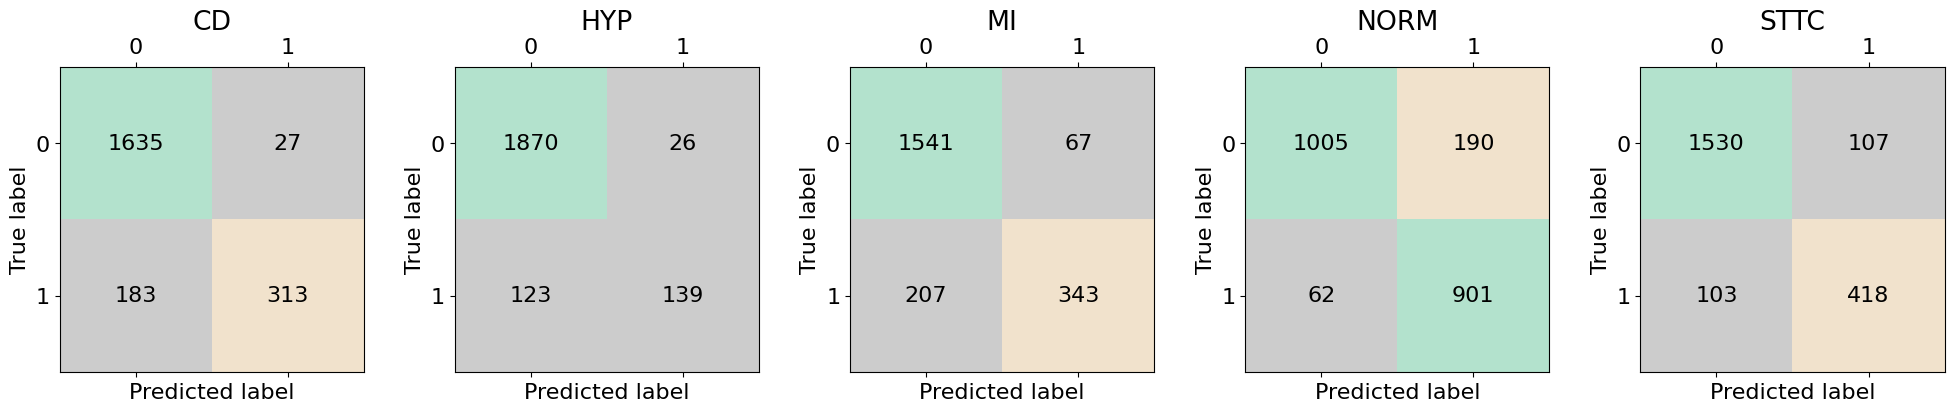

In [80]:
## import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np



# Определяем названия классов
classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Визуализация матриц ошибок в одну строку
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (matrix, class_name) in enumerate(zip(cm, classes)):
    axes[i].matshow(matrix, cmap="Pastel2_r")
    axes[i].set_title(class_name)
    for (j, k), value in np.ndenumerate(matrix):
        axes[i].text(k, j, f"{value}", ha='center', va='center')
    axes[i].set_xlabel("Predicted label")
    axes[i].set_ylabel("True label")

plt.tight_layout()
plt.show()


TypeError: Invalid shape (5, 2, 2) for image data

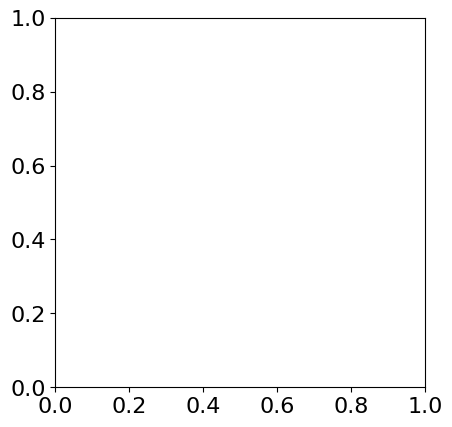

In [45]:
plot_confusion_matrix(cm, ['CD', 'HYP', 'MI', 'NORM', 'STTC'])

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (5).

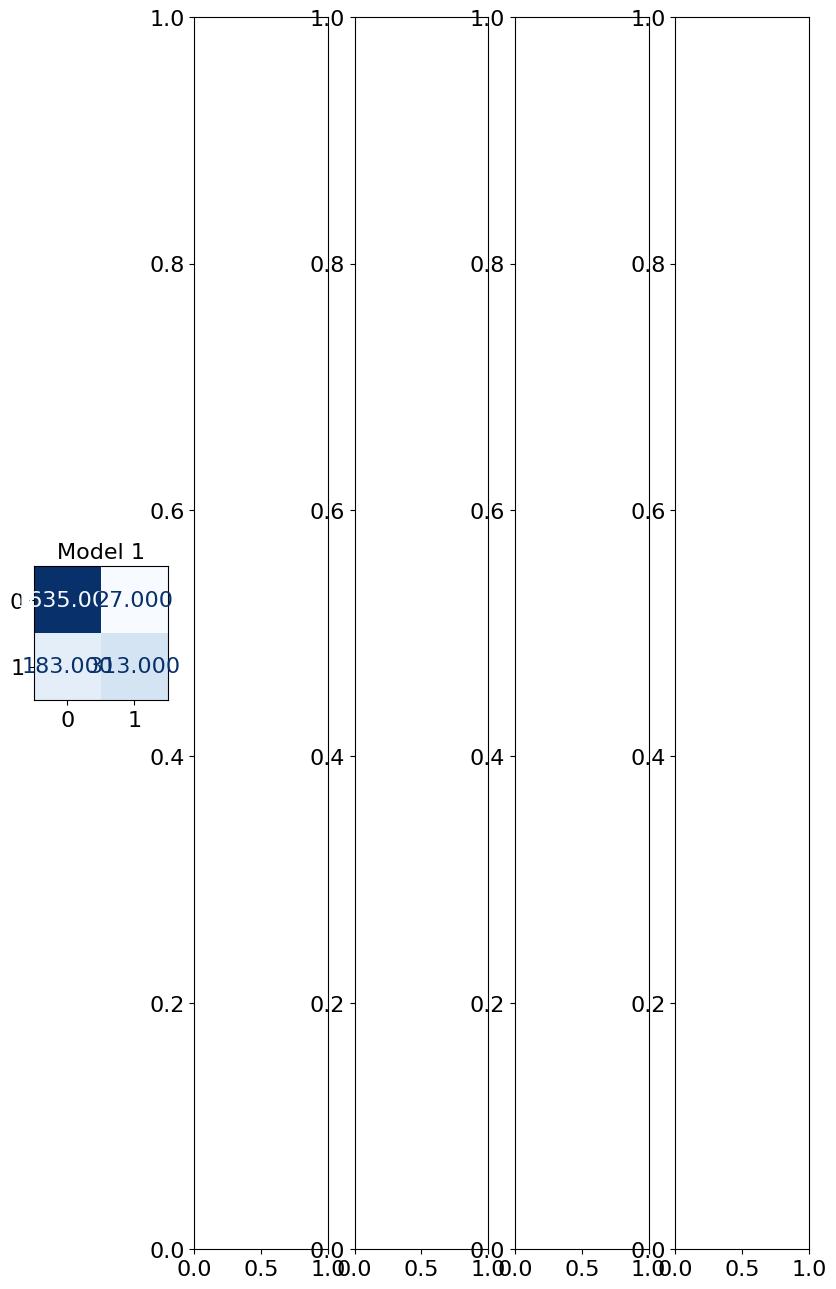

In [43]:
title_size = 16
plt.rcParams.update({'font.size':16})
display_labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']  
colorbar = False
cmap = "Blues"  # Try "Greens". Change the color of the confusion matrix.
## Please see other alternatives at https://matplotlib.org/stable/tutorials/colors/colormaps.html
values_format = ".3f"  # Determine the number of decimal places to be displayed.

# Create subplots for given confusion matrices
f, axes = plt.subplots(1, 5, figsize=(10, 16))

# Plot the first confusion matrix (Model 1) at position (0, 0)
axes[0, 0].set_title("Model 1", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar, values_format=values_format)

# # Remove x-axis labels and ticks
# axes[0, 0].xaxis.set_ticklabels(['', '', '', ''])
# axes[0, 0].set_xlabel('')
# axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


# # Plot the second confusion matrix (Model 2) at position (0, 1)
# axes[0, 1].set_title("Model 2", size=title_size)
# ConfusionMatrixDisplay(confusion_matrix=cm01, display_labels=display_labels).plot(
#     include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar, values_format=values_format)

In [1]:
gt

NameError: name 'gt' is not defined

In [92]:
classification_report(gt, y_pred)

C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n           0       0.92      0.63      0.75       496\n           1       0.84      0.53      0.65       262\n           2       0.84      0.62      0.71       550\n           3       0.83      0.94      0.88       963\n           4       0.80      0.80      0.80       521\n\n   micro avg       0.84      0.76      0.79      2792\n   macro avg       0.84      0.70      0.76      2792\nweighted avg       0.84      0.76      0.79      2792\n samples avg       0.80      0.78      0.78      2792\n'

# VGG 16

In [76]:
from torch_ecg.utils.utils_nn import adjust_cnn_filter_lengths
from torch_ecg.model_configs import ECG_CRNN_CONFIG
from torch_ecg.models.ecg_crnn import ECG_CRNN


# xresnet1d_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\xresnet1d101\exp0_xresnet1d101xresnet1d101_fold1_19epoch_best_score.pth'
# xresnet1d_model.load_state_dict(torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model'])
# xresnet1d_model.double()
# xresnet1d_model.eval()

vgg16_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\vgg16\vgg16_fold1_10epoch_best_score.pth'
config = adjust_cnn_filter_lengths(ECG_CRNN_CONFIG, fs=100)
config.cnn.name="vgg16"
classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
n_leads = 12
vgg16_model = ECG_CRNN(classes, n_leads, config)
vgg16_model.load_state_dict(torch.load(vgg16_model_weights_path, map_location=torch.device('cpu'))['model'])
vgg16_model.double()
vgg16_model.eval()

ECG_CRNN(
  (cnn): VGG16(
    (vgg_block_1): VGGBlock(
      (cba_1): Conv_Bn_Activation(
        (conv1d): Conv1d(12, 48, kernel_size=(3,), stride=(1,), padding=(1,))
        (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_ReLU): ReLU()
      )
      (cba_2): Conv_Bn_Activation(
        (conv1d): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
        (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_ReLU): ReLU()
      )
      (max_pool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (vgg_block_2): VGGBlock(
      (cba_1): Conv_Bn_Activation(
        (conv1d): Conv1d(48, 96, kernel_size=(3,), stride=(1,), padding=(1,))
        (batch_norm): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_ReLU): ReLU()
      )
      (cba_2): Conv_Bn_Activation(
        (co

In [25]:
gt, scores = evaluate_model(vgg16_model, test_dataset)

100%|██████████| 2158/2158 [00:34<00:00, 62.78it/s]

class wise accuracy: [0.9443929564411492, 0.9416126042632067, 0.9235403151065802, 0.9564411492122336, 0.9341983317886933]
accuracy: 0.9400370713623726
roc_score : 0.9778205177504251
class wise AUC : [0.9753952195178759, 0.9644631526395465, 0.9802702397105383, 0.9911260574303626, 0.9778479194538017]
F1 score (Max): 0.9046505804439674
class wise precision, recall, f1 score : (0.9046505804439674, 0.9778205177504251, [0.9046505804439674, 0.9038983394952643, 0.9031458501126676, 0.9015237484493674, 0.8957272207129167, 0.8915892787278965, 0.8850983564496786, 0.8792953346269956, 0.8728961897776523, 0.8668126507611201], [0.9299233349305223, 0.9368065605402798, 0.9421554370657619, 0.9476621049201693, 0.9491379310344827, 0.9539440838741887, 0.9573016675088428, 0.9636192432802603, 0.965057948451825, 0.96821215314366], [0.8807151683657708, 0.8732236638863144, 0.8672381835032438, 0.8596694470188445, 0.8480074142724745, 0.8368860055607044, 0.8230228606734632, 0.8085418597466791, 0.7968025949953661, 0

In [66]:
gt, scores = evaluate_model(vgg16_model, test_dataset)

100%|██████████| 2158/2158 [00:22<00:00, 96.43it/s] 

class wise accuracy: [0.9443929564411492, 0.9416126042632067, 0.9235403151065802, 0.9564411492122336, 0.9341983317886933]
accuracy: 0.9400370713623726
roc_score : 0.9778205177504251
class wise AUC : [0.9753952195178759, 0.9644631526395465, 0.9802702397105383, 0.9911260574303626, 0.9778479194538017]
F1 score (Max): 0.9046505804439674
class wise precision, recall, f1 score : (0.9046505804439674, 0.9778205177504251, [0.9046505804439674, 0.9038983394952643, 0.9031458501126676, 0.9015237484493674, 0.8957272207129167, 0.8915892787278965, 0.8850983564496786, 0.8792953346269956, 0.8728961897776523, 0.8668126507611201], [0.9299233349305223, 0.9368065605402798, 0.9421554370657619, 0.9476621049201693, 0.9491379310344827, 0.9539440838741887, 0.9573016675088428, 0.9636192432802603, 0.965057948451825, 0.96821215314366], [0.8807151683657708, 0.8732236638863144, 0.8672381835032438, 0.8596694470188445, 0.8480074142724745, 0.8368860055607044, 0.8230228606734632, 0.8085418597466791, 0.7968025949953661, 0

In [67]:
cm, y_pred = calculate_metrics(scores)

100%|██████████| 2158/2158 [00:00<00:00, 164736.97it/s]

Confusion matrix: 
 [[[1631   31]
  [  88  408]]

 [[1868   28]
  [  93  169]]

 [[1573   35]
  [ 104  446]]

 [[1116   79]
  [  25  938]]

 [[1590   47]
  [  80  441]]]

MR:  0.781

Accuracy:  0.857

0/1Loss:  0.219

Recall:  0.881

Precision:  0.899

Hamming loss:  0.056533827618164965


In [72]:
print(classification_report(gt, y_pred, target_names=classes))

              precision    recall  f1-score   support

          CD       0.93      0.82      0.87       496
         HYP       0.86      0.65      0.74       262
          MI       0.93      0.81      0.87       550
        NORM       0.92      0.97      0.95       963
        STTC       0.90      0.85      0.87       521

   micro avg       0.92      0.86      0.89      2792
   macro avg       0.91      0.82      0.86      2792
weighted avg       0.92      0.86      0.88      2792
 samples avg       0.90      0.88      0.88      2792



C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# MobileNet


In [27]:
mobilenet_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\mobilenet\mobilenet_v3_fold1_3epoch_best_score.pth'
config = adjust_cnn_filter_lengths(ECG_CRNN_CONFIG, fs=100)
config.cnn.name="mobilenet_v3"
classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
n_leads = 12
mobilenet = ECG_CRNN(classes, n_leads, config)
mobilenet.load_state_dict(torch.load(mobilenet_model_weights_path, map_location=torch.device('cpu'))['model'])
mobilenet.double()
mobilenet.eval()

ECG_CRNN(
  (cnn): MobileNetV3(
    (stem): MobileNetV3_STEM(
      (init_conv): Conv_Bn_Activation(
        (conv1d): Conv1d(12, 24, kernel_size=(5,), stride=(2,), padding=(2,))
        (batch_norm): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_ReLU): ReLU()
      )
    )
    (block_0): InvertedResidualBlock(
      (inv_res_0): InvertedResidual(
        (main_stream): Sequential(
          (expansion): Conv_Bn_Activation(
            (conv1d): Conv1d(24, 96, kernel_size=(1,), stride=(1,))
            (batch_norm): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation_ReLU): ReLU()
          )
          (depthwise_conv): Conv_Bn_Activation(
            (conv1d): Conv1d(96, 96, kernel_size=(3,), stride=(2,), padding=(1,), groups=96)
            (batch_norm): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation_ReLU): ReLU()
         

In [29]:
gt, scores = evaluate_model(mobilenet, test_dataset)

100%|██████████| 2158/2158 [05:48<00:00,  6.20it/s]


class wise accuracy: [0.8999073215940686, 0.9323447636700649, 0.8586654309545876, 0.8994439295644114, 0.901760889712697]
accuracy: 0.8984244670991659
roc_score : 0.9495002674831957
class wise AUC : [0.9391012577151509, 0.945415418558959, 0.9380269109000452, 0.9669555998731302, 0.9580021503686933]
F1 score (Max): 0.8181791569468833
class wise precision, recall, f1 score : (0.8181791569468833, 0.9495002674831957, [0.8181791569468833, 0.8152394938260943, 0.8117681358720336, 0.8072227926359807, 0.8028361461598871, 0.7944860354606909, 0.7886988645794696, 0.7842968287658761, 0.7788066548107536, 0.7690326215584468], [0.8542575537243497, 0.862151067323481, 0.8692326980942828, 0.877491057741441, 0.8852266805627931, 0.8883430695698353, 0.8950533550370773, 0.9044117647058824, 0.9147187381223868, 0.9208699902248288], [0.7850247142415818, 0.7731696014828545, 0.7614303367315416, 0.7473741118319431, 0.7344763670064874, 0.7185665739882607, 0.704935125115848, 0.6923463083101637, 0.6780583873957368, 0.6

# RegNet

In [30]:
# C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\regnet\regnet_27_24_fold1_10epoch_best_score.pth
regnet_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\regnet\regnet_27_24_fold1_10epoch_best_score.pth'
config = adjust_cnn_filter_lengths(ECG_CRNN_CONFIG, fs=100)
config.cnn.name="regnet_27_24"
classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
n_leads = 12
regnet = ECG_CRNN(classes, n_leads, config)
regnet.load_state_dict(torch.load(regnet_model_weights_path, map_location=torch.device('cpu'))['model'])
regnet.double()
regnet.eval()

ECG_CRNN(
  (cnn): RegNet(
    (input_stem): RegNetStem(
      (conv_0): Conv_Bn_Activation(
        (conv1d): Conv1d(12, 64, kernel_size=(5,), stride=(2,), padding=(2,))
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_ReLU): ReLU()
      )
      (pool): DownSample(
        (down_sample): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (stage_0): AnyStage(
      (block_0_0): ResNetBottleNeck(
        (shortcut): DownSample(
          (down_sample): Conv1d(64, 48, kernel_size=(1,), stride=(2,), bias=False)
          (batch_normalization): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (main_stream): Sequential(
          (cba_head): Conv_Bn_Activation(
            (conv1d): Conv1d(64, 48, kernel_size=(1,), stride=(1,), bias=False)
            (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_runn

In [31]:
gt, scores = evaluate_model(regnet, test_dataset)

100%|██████████| 2158/2158 [01:36<00:00, 22.32it/s]

class wise accuracy: [0.8758109360518999, 0.9272474513438369, 0.8493975903614458, 0.9161260426320668, 0.9133456904541242]
accuracy: 0.8963855421686748
roc_score : 0.9392373779179364
class wise AUC : [0.9129461686269944, 0.9160707958901021, 0.9332293080054274, 0.9730974943190952, 0.9608431227480633]
F1 score (Max): 0.8228014495736116
class wise precision, recall, f1 score : (0.8228014495736116, 0.9392373779179364, [0.8228014495736116, 0.8186749577524243, 0.8166158056078442, 0.8111439258339307, 0.802645738012891, 0.8009632117971975, 0.7916247149679855, 0.7837633487569987, 0.7753208601472028, 0.7624940376443793], [0.8578455284552845, 0.8667163684559311, 0.8754196038939243, 0.8812756147540983, 0.8872420426722631, 0.8980591168091168, 0.9030054644808743, 0.9120187793427231, 0.9179219775975279, 0.9239783653846154], [0.790508186592524, 0.775679641643497, 0.7652147049737411, 0.7513515600864997, 0.7327772628977448, 0.7228143342601173, 0.7047034291010195, 0.6871331479765216, 0.6710688909484089, 0

In [38]:
gt, scores = evaluate_model(regnet, test_dataset)

100%|██████████| 2158/2158 [01:50<00:00, 19.61it/s]

class wise accuracy: [0.8883225208526413, 0.9291010194624653, 0.8688600556070436, 0.9138090824837812, 0.906858202038925]
accuracy: 0.9013901760889713
roc_score : 0.9392373779179364
class wise AUC : [0.9129461686269944, 0.9160707958901021, 0.9332293080054274, 0.9730974943190952, 0.9608431227480633]
F1 score (Max): 0.8397177359483794
class wise precision, recall, f1 score : (0.8397177359483794, 0.9392373779179364, [0.41113238109262257, 0.786229692962842, 0.8308098315964298, 0.8397177359483794, 0.8322756725680879, 0.8166158056078442, 0.7905771325832022, 0.7440019013384844, 0.6315029125056157, nan], [0.258758109360519, 0.6729147358665432, 0.768303985171455, 0.8178754067875407, 0.8459403742467491, 0.8754196038939243, 0.9060205580029369, 0.9356687898089172, 0.9645602049530316, nan], [1.0, 0.9454355885078776, 0.9043867778807537, 0.8627587272165587, 0.8190454124189064, 0.7652147049737411, 0.7012279888785913, 0.6175084955205437, 0.469416126042632, 0.0], [0.0, 0.1111111111111111, 0.2222222222222

In [39]:
scores

array([[8.52519921e-03, 3.75845225e-04, 2.86774804e-03, 9.94029427e-01,
        5.24788376e-05],
       [9.07293666e-02, 2.90881560e-03, 6.01605381e-02, 8.70344206e-01,
        2.27302275e-02],
       [2.04408104e-02, 2.79763932e-03, 9.21883939e-03, 9.76920905e-01,
        3.40483473e-03],
       ...,
       [7.16723957e-02, 7.48383336e-02, 4.70268201e-02, 8.30500856e-01,
        7.76996174e-03],
       [7.02959345e-01, 3.41441322e-02, 5.95875369e-01, 7.18140129e-02,
        3.58954671e-02],
       [6.97037598e-02, 2.25118027e-02, 2.64048073e-01, 2.04948933e-01,
        5.28933500e-01]])

In [75]:
config

{'fs': 100, 'cnn': {'name': 'regnet_27_24', 'vgg16': {'fs': 100, 'num_convs': [2, 2, 3, 3, 3], 'num_filters': [48, 96, 192, 384, 384], 'groups': 1, 'kernel_initializer': 'he_normal', 'kw_initializer': {}, 'activation': 'relu', 'kw_activation': {}, 'block': {'filter_length': 3, 'subsample_length': 1, 'dilation': 1, 'batch_norm': True, 'pool_size': 3, 'pool_stride': 2, 'kernel_initializer': 'he_normal', 'kw_initializer': {}, 'activation': 'relu', 'kw_activation': {}}}, 'vgg16_mish': {'fs': 100, 'num_convs': [2, 2, 3, 3, 3], 'num_filters': [48, 96, 192, 384, 384], 'groups': 1, 'kernel_initializer': 'he_normal', 'kw_initializer': {}, 'activation': 'relu', 'kw_activation': {}, 'block': {'filter_length': 3, 'subsample_length': 1, 'dilation': 1, 'batch_norm': True, 'pool_size': 3, 'pool_stride': 2, 'kernel_initializer': 'he_normal', 'kw_initializer': {}, 'activation': 'mish', 'kw_activation': {}}}, 'vgg16_swish': {'fs': 100, 'num_convs': [2, 2, 3, 3, 3], 'num_filters': [48, 96, 192, 384, 384]


(dot.exe:123448): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


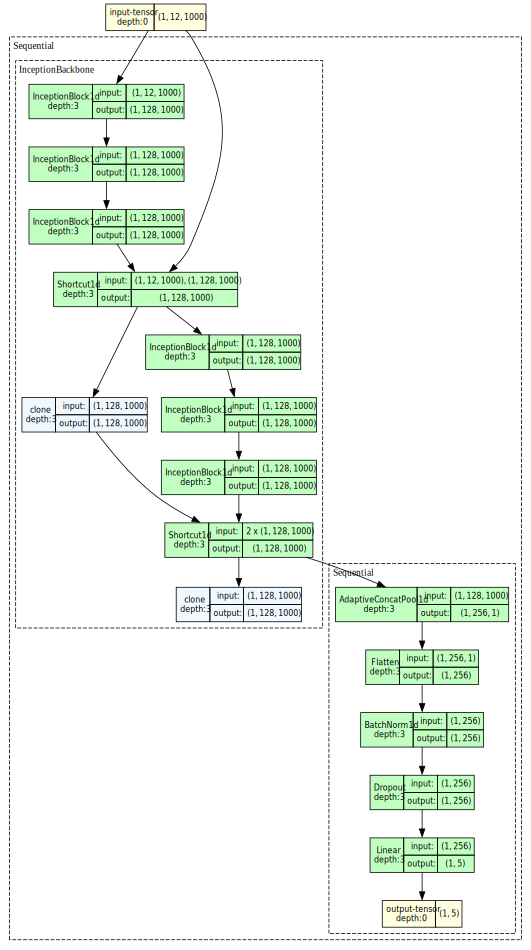

In [107]:
import torchvision
from torchview import draw_graph
# import

model_graph = draw_graph(inception1d(input_channels=12, num_classes=5), input_size=( 1, 12, 1000), expand_nested=True)
model_graph.visual_graph


(dot.exe:123096): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


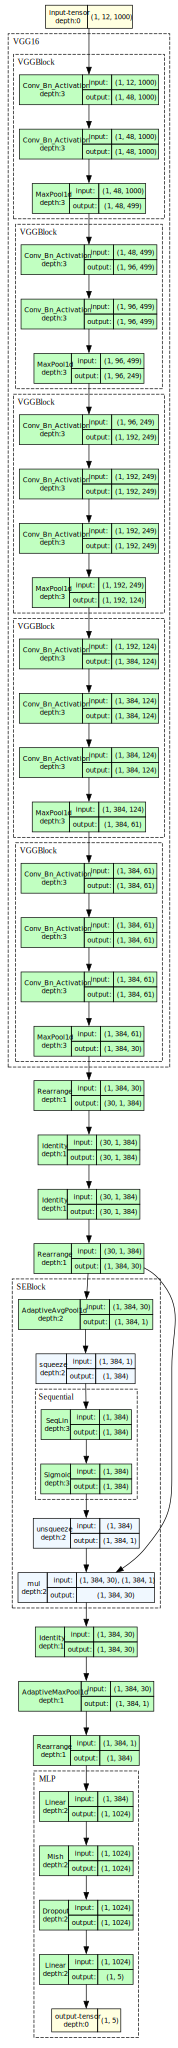

In [110]:
config = adjust_cnn_filter_lengths(ECG_CRNN_CONFIG, fs=100)
config.cnn.name="vgg16"
classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
n_leads = 12
# vgg16_model = ECG_CRNN(classes, n_leads, config)



model_graph = draw_graph(ECG_CRNN(classes, n_leads, config), input_size=(1, 12, 1000), expand_nested=True)
model_graph.visual_graph

In [9]:
class SimpleRNN(torch.nn.Module):
    """Simple RNN"""

    def __init__(self, inplace: bool = True) -> None:
        super().__init__()
        self.hid_dim = 2
        self.input_dim = 3
        self.max_length = 4
        self.lstm = torch.nn.LSTMCell(self.input_dim, self.hid_dim)
        self.activation = torch.nn.LeakyReLU(inplace=inplace)
        self.projection = torch.nn.Linear(self.hid_dim, self.input_dim)

    def forward(self, token_embedding: torch.Tensor) -> torch.Tensor:
        b_size = token_embedding.size()[0]
        hx = torch.randn(b_size, self.hid_dim, device=token_embedding.device)
        cx = torch.randn(b_size, self.hid_dim, device=token_embedding.device)

        for _ in range(self.max_length):
            hx, cx = self.lstm(token_embedding, (hx, cx))
            hx = self.activation(hx)

        return hx

In [97]:
model_graph_1 = draw_graph(
    SimpleRNN(), input_size=(2, 3),
    graph_name='RecursiveNet',
    roll=True
)


(dot.exe:120320): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


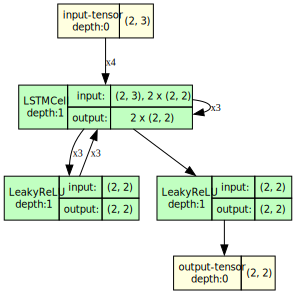

In [100]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-11.0.0-win64/bin/'
model_graph_1.visual_graph


(dot.exe:125516): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


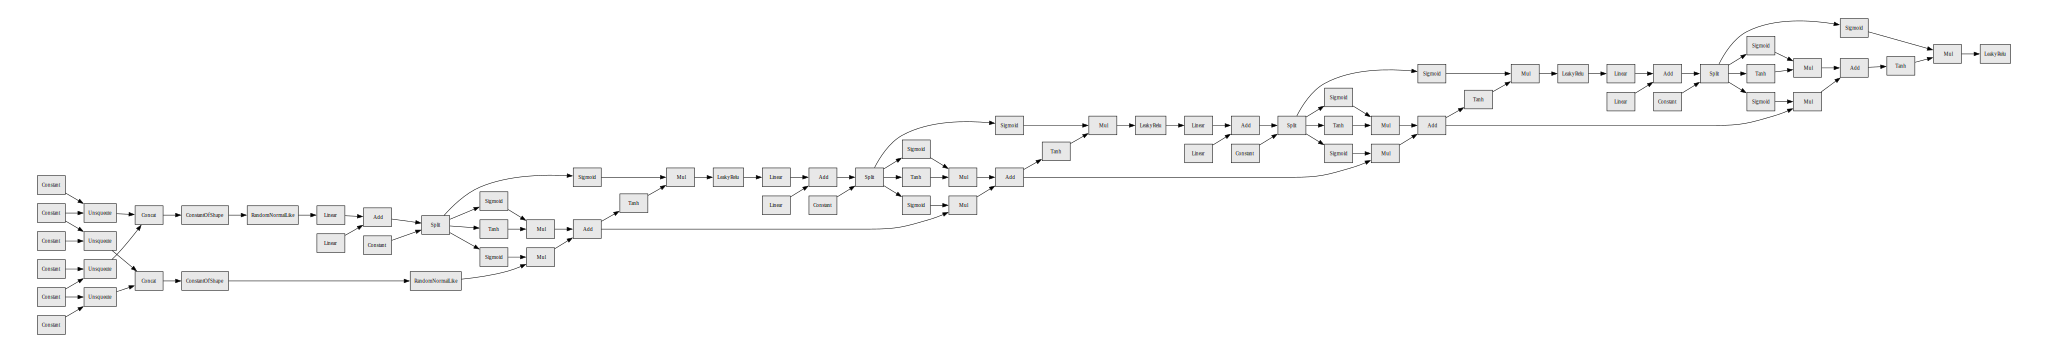

In [11]:
## import hiddenlayer as hl
import torchvision
import torch
from torchview import draw_graph
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-11.0.0-win64/bin/'

# AlexNet
model = torchvision.models.alexnet()

# Build HiddenLayer graph
hl_graph = hl.build_graph(SimpleRNN(), torch.zeros([2, 3])).build_dot()

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

In [113]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 